# Siamese: Face Recognition (Triplet Loss)

## Help

Connecting to your GoogleDrive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

import a library from GoogleDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

your_module = drive.CreateFile({'id':'1NfzAHWYwC-5MEzg6VmrdJmUCGUltFHL6'})
your_module1 = drive.CreateFile({'id':'1LOy3fJ6Az0W2ZvJHXxzLdspo71Ygmui0'})
your_module2 = drive.CreateFile({'id':'1SITwO4kHFgaeQWxtQJoMmPsXLUhaR5Of'})

your_module.GetContentFile('utils.py')
your_module1.GetContentFile('data_utils.py')
your_module2.GetContentFile('train.py')

## Library

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from data_utils import create_validation_data

exit_gpu = torch.cuda.is_available()

In [ ]:
print(exit_gpu)

## Create validation data

In [ ]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)


def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

In [10]:
DATA_DIR = 'data/'
train_dir = f'{DATA_DIR}train'
valid_dir = f'{DATA_DIR}valid'

sz = 224
batch_size = 4
embed_size = 128
num_epochs = 10
num_workers = 2

cnn_name = 'resnet18'

## Create validation data

In [11]:
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.20, ext='jpg')

  0%|                                                                                           | 0/37 [00:00<?, ?it/s]

189
37


100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 701.36it/s]


## Dataset

In [12]:
class myDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform
        
    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]
        
        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])
        
        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')
        
        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anc_img, pos_img, neg_img
    
    def __len__(self):
        return len(self.imgs)

In [40]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom
states = ([0.50480222,0.4073655,0.37700788],[0.29478898,0.25199998,0.2384155])
tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(*states)
])

# train data
face_dataset = datasets.ImageFolder(train_dir)
train_ds = myDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# validation data

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = myDataset(valid_face_dataset.imgs, transform=tfms)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


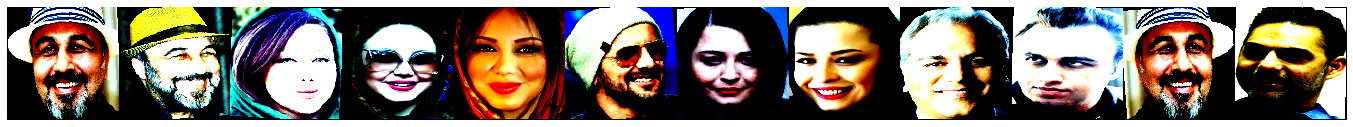

In [23]:
anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl))
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 3)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))

## Model

In [18]:
class myNetwork(nn.Module):
    
    def __init__(self, model, embed_size):
        super(myNetwork, self).__init__()
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),           
            nn.Linear(512, embed_size))
        self.model = model
        
    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

## Loss function

In [21]:
class myLoss(nn.Module):

    def __init__(self, margin=0.2):
        super(myLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - \
                                     torch.pow(neg_distance, 2) + self.margin, min=0))
        return loss

In [24]:
# model
cnn = get_model(cnn_name)
model = myNetwork(cnn, embed_size)

# loss and optimizer
criterion = myLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

if(exit_gpu):
    model = model.cuda()
    criterion = criterion.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\ako.KURDISTANMET/.cache\torch\checkpoints\resnet18-5c106cde.pth


## Train

In [29]:
def train_step(model, train_dl, criterion, optimizer, scheduler=None):
    model.train()
    if scheduler:
        scheduler.step()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(train_dl):
        #anc, pos, neg = Variable(anc).cuda(), Variable(pos).cuda(), Variable(neg).cuda()
        
        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        
        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        # *************************************************
        avg_loss = (avg_loss * i + loss.data) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(valid_dl):
        #anc = Variable(anc, volatile=True).cuda()
        #pos = Variable(pos, volatile=True).cuda()
        #neg = Variable(neg, volatile=True).cuda()
        
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data) / (i + 1)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()
    
    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler=None, num_epochs=100):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}\n--------')
        model, train_loss = train_step(model, train_dl, criterion, optimizer, scheduler)
        valid_loss = validate_step(model, valid_dl, criterion)
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
    loss_history = (train_loss_history, valid_loss_history)
    return model, best_weights, loss_history

In [30]:
model, best_weights, loss_hist = train(model, train_dl, valid_dl, 
                                       criterion, optimizer, scheduler, 
                                       num_epochs=num_epochs)

Epoch 0
--------
 Training Step [41/40]: loss 5.02073   
 Validation Step [10/ 9]: loss 3.16416  

Epoch 1
--------
 Training Step [41/40]: loss 4.87709  
 Validation Step [10/ 9]: loss 4.76873  

Epoch 2
--------
 Training Step [41/40]: loss 3.73361  
 Validation Step [10/ 9]: loss 5.38737  

Epoch 3
--------
 Training Step [41/40]: loss 5.20322   
 Validation Step [10/ 9]: loss 0.82644  

Epoch 4
--------
 Training Step [41/40]: loss 4.11547  
 Validation Step [10/ 9]: loss 12.23177  

Epoch 5
--------
 Training Step [41/40]: loss 5.59530  
 Validation Step [10/ 9]: loss 5.96499  

Epoch 6
--------
 Training Step [41/40]: loss 6.51910   
 Validation Step [10/ 9]: loss 2.98388  

Epoch 7
--------
 Training Step [41/40]: loss 2.15149  
 Validation Step [10/ 9]: loss 1.93391  

Epoch 8
--------
 Training Step [41/40]: loss 4.13157   
 Validation Step [10/ 9]: loss 2.40818  

Epoch 9
--------
 Training Step [41/40]: loss 2.81023  
 Validation Step [10/ 9]: loss 4.16995   



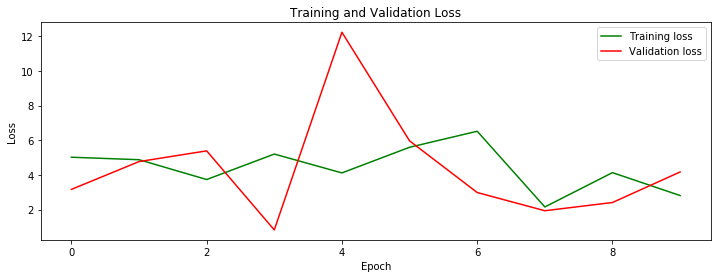

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

In [ ]:
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 3)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pos dis: tensor([3.0154], grad_fn=<NormBackward1>) neg dis: tensor([4.9296], grad_fn=<NormBackward1>)


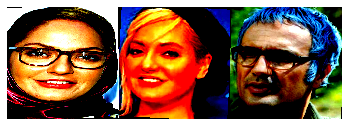

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pos dis: tensor([3.2647], grad_fn=<NormBackward1>) neg dis: tensor([4.2777], grad_fn=<NormBackward1>)


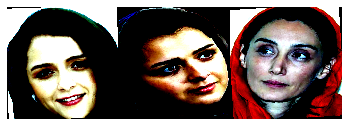

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pos dis: tensor([2.2708], grad_fn=<NormBackward1>) neg dis: tensor([3.8816], grad_fn=<NormBackward1>)


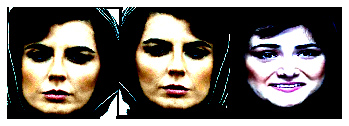

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pos dis: tensor([1.3976], grad_fn=<NormBackward1>) neg dis: tensor([5.2219], grad_fn=<NormBackward1>)


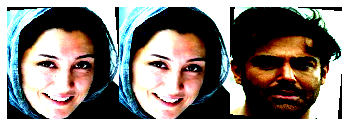

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pos dis: tensor([1.9621], grad_fn=<NormBackward1>) neg dis: tensor([6.2690], grad_fn=<NormBackward1>)


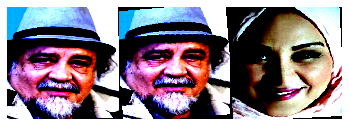

In [44]:
model.eval()

dataiter = iter(valid_dl)
for i in range(5):
    x0, x1, x2 = next(dataiter)
    concat = torch.cat((x0, x1, x2), 3)
    f0, f1, f2 = model(x0, x1, x2)
    #f0, f1, f2 = model(Variable(x0).cuda(), Variable(x1).cuda(), Variable(x2).cuda())
    pos_distance = F.pairwise_distance(f0, f1)
    neg_distance = F.pairwise_distance(f0, f2)
    print('pos dis:',pos_distance,'neg dis:',neg_distance)
    imshow(torchvision.utils.make_grid(concat, nrow=8))